## 📚 1. Setup & Imports

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from transformers import (
    DistilBertTokenizerFast,
    TFDistilBertForSequenceClassification,
    DataCollatorWithPadding,
    create_optimizer
)

import evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.


## 📄 2. Load & Explore Data

In [ ]:
# Load dataset
df = pd.read_csv("../datasets/labelled.csv")

# Display first few rows
df.head()


,Heading,Body,Category,URL
0,free speech not hate speech madras high court ...,madras high court issue significant remark ami...,Judiciary,https://www.indiatoday.in/law/high-courts/stor...
1,comment take context say us cop mock indian st...,seattle police officer guild friday come defen...,Crime,https://www.indiatoday.in/world/story/indian-s...
2,first meeting one nation one election committe...,first official meeting one nation one election...,Politics,https://www.indiatoday.in/india/story/one-nati...
3,us airlines flight depressurize midair plummet...,united airlines jet head rome turn around less...,Crime,https://www.indiatoday.in/world/story/us-fligh...
4,terrorist kill security force foil infiltratio...,three terrorist kill infiltration bid foil sec...,Crime,https://www.indiatoday.in/india/story/one-terr...


In [3]:
# Check for missing values
df.isnull().sum()


,0
Heading,0
Body,0
Category,0
URL,0


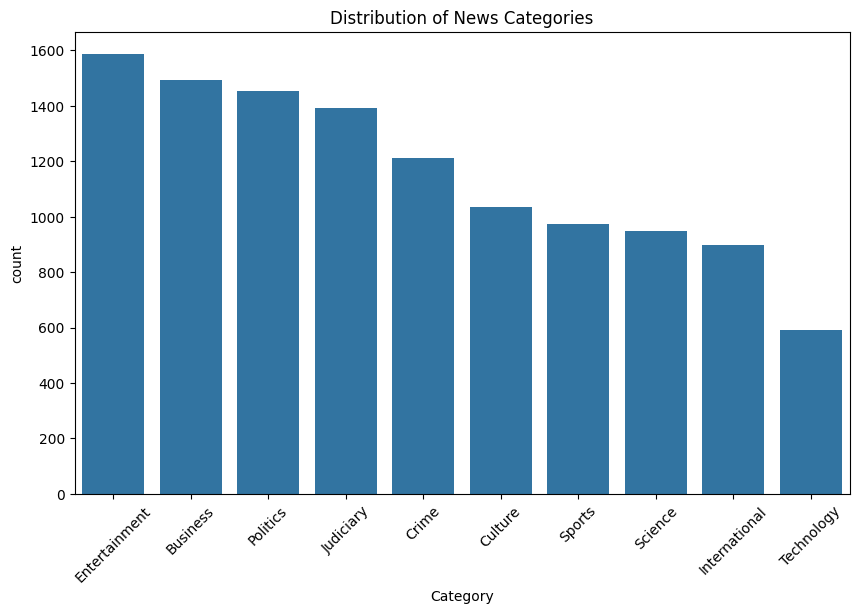

In [4]:
# Distribution of categories
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index)
plt.title("Distribution of News Categories")
plt.xticks(rotation=45)
plt.show()


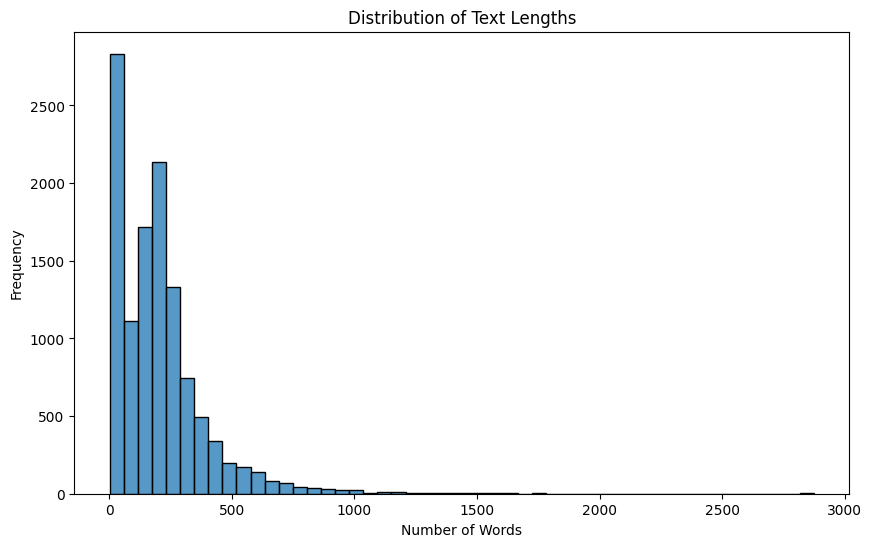

In [5]:
# Add a column for text length
df['Text_Length'] = df['Body'].apply(lambda x: len(str(x).split()))

# Plot text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Text_Length'], bins=50)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


## 🧹 3. Preprocessing

In [6]:
# Define category encoding
category_mapping = {
    "Entertainment": 0,
    "Business": 1,
    "Politics": 2,
    "Judiciary": 3,
    "Crime": 4,
    "Culture": 5,
    "Sports": 6,
    "Science": 7,
    "International": 8,
    "Technology": 9
}

# Map categories to numerical labels
df['Label'] = df['Category'].map(category_mapping)

# Drop rows with missing values in 'Body' or 'Label'
df.dropna(subset=['Body', 'Label'], inplace=True)


## ✂️ 4. Train-Test Split

In [7]:
# Split data into training, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Body'].tolist(),
    df['Label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['Label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)


## 🔢 5. Tokenization

In [8]:
# Initialize tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## 📦 6. Prepare TensorFlow Datasets

In [9]:
# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))


## 🧠 7. Build & Compile Model

In [10]:
# Load pre-trained DistilBERT model with a classification head
model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=10
)

# Create optimizer
batch_size = 16
num_train_steps = len(train_dataset) // batch_size * 3  # 3 epochs
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

## 🚀 8. Train the Model

In [11]:
# Prepare datasets for training
train_dataset = train_dataset.shuffle(1000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)


Epoch 1/3
580/580 [==============================] - 541s 892ms/step - loss: 1.0640 - accuracy: 0.6979 - val_loss: 0.7372 - val_accuracy: 0.7729
Epoch 2/3
580/580 [==============================] - 517s 892ms/step - loss: 0.6166 - accuracy: 0.8194 - val_loss: 0.7010 - val_accuracy: 0.7815
Epoch 3/3
580/580 [==============================] - 517s 892ms/step - loss: 0.4801 - accuracy: 0.8680 - val_loss: 0.7016 - val_accuracy: 0.7807


## 📈 9. Evaluate the Model

In [12]:
# Prepare test dataset
test_dataset = test_dataset.batch(batch_size)

# Evaluate on test data
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


73/73 [==============================] - 22s 295ms/step - loss: 0.6680 - accuracy: 0.7938
Test Loss: 0.6680114269256592
Test Accuracy: 0.7937877774238586


73/73 [==============================] - 23s 293ms/step
               precision    recall  f1-score   support

Entertainment       0.91      0.86      0.89       159
     Business       0.79      0.78      0.79       150
     Politics       0.81      0.76      0.79       145
    Judiciary       0.63      0.66      0.64       140
        Crime       0.81      0.88      0.85       121
      Culture       0.65      0.62      0.63       104
       Sports       0.91      0.92      0.91        97
      Science       0.79      0.85      0.82        95
International       0.78      0.78      0.78        89
   Technology       0.93      0.92      0.92        59

     accuracy                           0.79      1159
    macro avg       0.80      0.80      0.80      1159
 weighted avg       0.80      0.79      0.79      1159



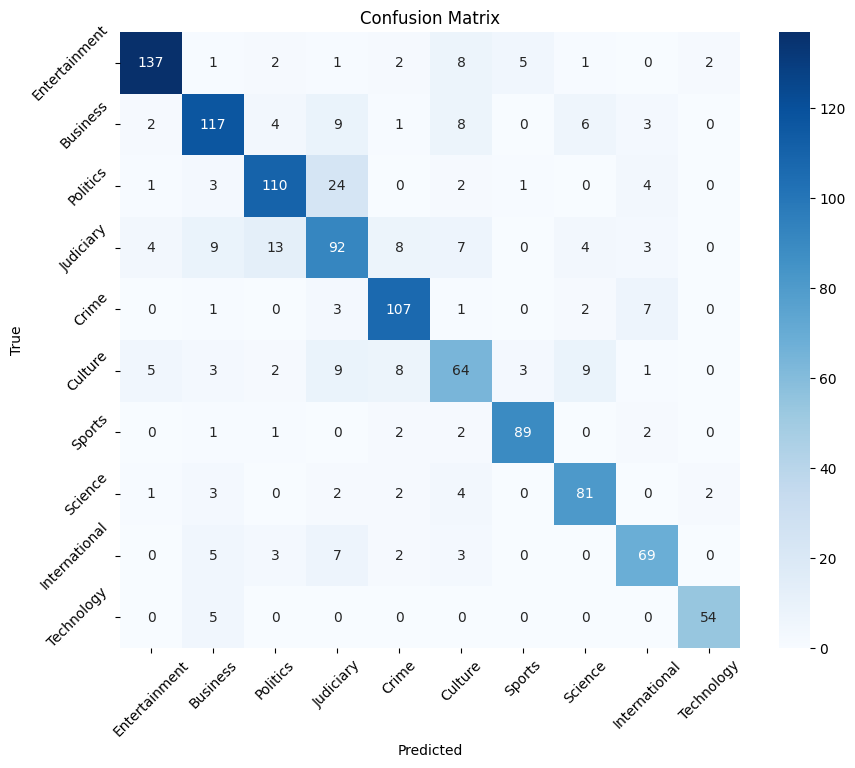

In [13]:
# Generate predictions
predictions = model.predict(test_dataset).logits
predicted_labels = np.argmax(predictions, axis=1)

# Classification report
print(classification_report(test_labels, predicted_labels, target_names=category_mapping.keys()))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=category_mapping.keys(), yticklabels=category_mapping.keys(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


## 💾 10. Save the Model

In [ ]:
# Save the trained model
model.save_pretrained("distillbert_news_classifier")
tokenizer.save_pretrained("distillbert_news_classifier")


('distilbert_news_classifier/tokenizer_config.json',
 'distilbert_news_classifier/special_tokens_map.json',
 'distilbert_news_classifier/vocab.txt',
 'distilbert_news_classifier/added_tokens.json',
 'distilbert_news_classifier/tokenizer.json')

## 🔍 11. Inference on New Data

In [15]:
def predict_category(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)

    # Get model predictions
    outputs = model(inputs)
    logits = outputs.logits
    predicted_label = tf.argmax(logits, axis=1).numpy()[0]

    # Map label to category
    for category, label in category_mapping.items():
        if label == predicted_label:
            return category

# Example usage
sample_text = "The government has announced new policies to boost the economy."
predicted_category = predict_category(sample_text)
print(f"Predicted Category: {predicted_category}")


Predicted Category: Business


In [ ]:
# Load the model and perfrom inference

from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast
import tensorflow as tf
import numpy as np

# Load the saved model and tokenizer
model = TFDistilBertForSequenceClassification.from_pretrained("distillbert_news_classifier")
tokenizer = DistilBertTokenizerFast.from_pretrained("distillbert_news_classifier")

category_mapping = {
    "Entertainment": 0,
    "Business": 1,
    "Politics": 2,
    "Judiciary": 3,
    "Crime": 4,
    "Culture": 5,
    "Sports": 6,
    "Science": 7,
    "International": 8,
    "Technology": 9
}

def predict_category(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    outputs = model(inputs)
    logits = outputs.logits
    predicted_label = tf.argmax(logits, axis=1).numpy()[0]
    for category, label in category_mapping.items():
        if label == predicted_label:
            return category
    return "Unknown" # Handle cases where no matching category is found

# Example usage:
sample_text = "A new study reveals groundbreaking findings in quantum computing."
predicted_category = predict_category(sample_text)
print(f"Predicted Category: {predicted_category}")

sample_text = "The latest blockbuster movie has broken box office records."
predicted_category = predict_category(sample_text)
print(f"Predicted Category: {predicted_category}")


Some layers from the model checkpoint at distilbert_news_classifier were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert_news_classifier and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted Category: Science
Predicted Category: Entertainment
